In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Feb  4 10:26:32 2021

@author: nuvilabs
"""
import torch
from random import randint
import random
class SMOTE(object):
    def __init__(self,distance='euclidian',dims=512,k=5):
        super(SMOTE,self).__init__()
        self.newindex = 0 
        self.k = k
        self.dims = dims
        self.distance_measure = distance
        
    def populate(self, N,i,nnarray,min_samples,k):
        while N:
            nn = randint(0, k-3)

            temp = min_samples[nnarray[nn]][0][0]
            diff = temp - min_samples[i]
            gap = random.uniform(0,1)

            test = min_samples[i] + gap * diff
            self.synthetic_arr[self.newindex,:] = test.view([-1])
            
            self.newindex += 1
            
            N -= 1
    def k_neighbors(self, euclid_distance, k):
        nearest_idx = torch.zeros((euclid_distance.shape[0],euclid_distance.shape[1],euclid_distance.shape[2],euclid_distance.shape[3]), dtype = torch.int64)
        
        idxs = torch.argsort(euclid_distance, dim=1)
        nearest_idx[:,:] = idxs
        
        return nearest_idx[:,0:k]
    
    def find_k(self,X,k):
        euclid_distance = torch.zeros((X.shape[0],X.shape[1],X.shape[2],X.shape[3]), dtype = torch.float32)
        
        for i in range(len(X)):
            dif = (X - X[i])**2
            dist = torch.sqrt(dif.sum(axis=1))
            euclid_distance[i] = dist[i]
            
        return self.k_neighbors(euclid_distance,k)
    
    def generate(self, min_samples, N,k):
        """
            Returns (N/100) * n_minority_samples synthetic minority samples.
    		Parameters
    		----------
    		min_samples : Numpy_array-like, shape = [n_minority_samples, n_features]
    		    Holds the minority samples
    		N : percetange of new synthetic samples: 
    		    n_synthetic_samples = N/100 * n_minority_samples. Can be < 100.
    		k : int. Number of nearest neighbours. 
    		Returns
    		-------
    		S : Synthetic samples. array, 
    		    shape = [(N/100) * n_minority_samples, n_features]. 
    	"""
        T = min_samples.shape[0]
        self.synthetic_arr = torch.zeros(int(N/100)*T,self.dims)
        N = int(N/100)
        if self.distance_measure == 'euclidian':
            indices = self.find_k(min_samples,k)
        for i in range(indices.shape[0]):
            self.populate(N, i, indices[i], min_samples, k)
        self.newindex = 0 
        return self.synthetic_arr
            
    def fit_generate(self,X,y):
        #get occurence of each class
        occ = torch.eye(int(y.max()+1),int(y.max()+1))[y].sum(axis=0)
        #get the dominant class
        dominant_class = torch.argmax(occ)
        #get occurence of the dominant class
        n_occ = int(occ[dominant_class].item())
        for i in range(len(occ)):
            if i != dominant_class:
                #calculate the amount of synthetic data to generate
                N = (n_occ - occ[i]) * 100 / occ[i]
                candidates = X[y == i]
                xs = self.generate(candidates, N,self.k).view([-1, 3, 32, 32])
                X = torch.cat((X,xs))
                ys = torch.ones(xs.shape[0]) * i
                y = torch.cat((y,ys))
                print("done")
        return X,y


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from vgg19 import *
import numpy as np

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

learning_rate = 0.001
training_epochs = 20
batch_size = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

model = VGG('VGG19').to(device)

if __name__ == '__main__':
    set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

    trainloader = torch.utils.data.DataLoader(set, batch_size = 50000, num_workers = 2, shuffle = True)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

    train_images, train_labels = iter(trainloader).next()

    train_images = np.array(train_images)
    train_labels = np.array(train_labels)

    trainset = []
    trainlabel = []

    cnt = [0] * 2
    for i in range(50000):
        if train_labels[i] > 1:
                continue
        if train_labels[i] == 1:
            if cnt[train_labels[i]] >= 500:
                continue
        trainset.append(train_images[i])
        trainlabel.append(train_labels[i])
        cnt[train_labels[i]] += 1

    print(trainlabel)

    traindata = np.array(trainset)
    trainlabel = np.array(trainlabel)
    train_images_tensor = torch.tensor(traindata)
    train_labels_tensor = torch.tensor(trainlabel, dtype = torch.long)
    trainset = torch.utils.data.TensorDataset(train_images_tensor, train_labels_tensor)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size = 5500, num_workers = 2, shuffle = True)

    total_batch = len(trainloader)
    print(total_batch)
    
    train_images, train_labels = iter(trainloader).next()

Files already downloaded and verified
Files already downloaded and verified
[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,

In [9]:
smote = SMOTE(dims=3072)
x, y = smote.fit_generate(train_images, train_labels)

done


In [26]:
print(x)

tensor([[[[ 2.7059e-01,  2.3922e-01,  2.4706e-01,  ...,  2.1569e-01,
            2.1569e-01,  2.1569e-01],
          [ 2.6275e-01,  2.4706e-01,  2.3922e-01,  ...,  2.2353e-01,
            2.2353e-01,  2.1569e-01],
          [ 2.7843e-01,  2.6275e-01,  2.3922e-01,  ...,  2.2353e-01,
            2.2353e-01,  2.2353e-01],
          ...,
          [ 3.0980e-01,  2.9412e-01,  2.9412e-01,  ...,  2.3922e-01,
            2.5490e-01,  2.6275e-01],
          [ 3.0980e-01,  2.9412e-01,  2.9412e-01,  ...,  2.4706e-01,
            2.4706e-01,  2.4706e-01],
          [ 3.0980e-01,  2.8627e-01,  2.8627e-01,  ...,  2.3922e-01,
            2.3922e-01,  2.3922e-01]],

         [[ 4.2745e-01,  4.0392e-01,  4.0392e-01,  ...,  3.4902e-01,
            3.4902e-01,  3.4902e-01],
          [ 4.4314e-01,  4.1176e-01,  4.2745e-01,  ...,  3.5686e-01,
            3.5686e-01,  3.4902e-01],
          [ 4.2745e-01,  3.8039e-01,  4.2745e-01,  ...,  3.5686e-01,
            3.5686e-01,  3.5686e-01],
          ...,
     

In [16]:
y=torch.tensor(y, dtype=torch.long)

<ipython-input-16-f5d1440d4bb8>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(y, dtype=torch.long)


In [38]:
trainset = torch.utils.data.TensorDataset(x, y)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 8, num_workers = 2, shuffle = True)

total_batch = len(trainloader)
print(total_batch)

1250


In [18]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [20]:
for epoch in range(10):
    avg_cost = 0

    for X, Y in trainloader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y느 ㄴ레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)

        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

    PATH = './test.pth'
    torch.save(model.state_dict(), PATH)

[Epoch:    1] cost = 0.224252865
[Epoch:    2] cost = 0.0850600302


KeyboardInterrupt: 

In [36]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
import matplotlib.pyplot as plt


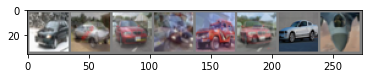

  car   car   car   car


In [52]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))